## Importy i przygotowanie

In [78]:
!pip install pandas networkx matplotlib ace-tools scipy pyvis requests tqdm uvicorn fastapi pytest

In [79]:
import xml.etree.ElementTree as ET
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from collections import defaultdict
import numpy as np
from pyvis.network import Network

xml_file = 'drugbank_partial.xml'
tree = ET.parse(xml_file)
root = tree.getroot()
namespace = {'db': 'http://www.drugbank.ca'}

## Zadanie 1

In [80]:
drugs_data = []

for drug in root.findall('db:drug', namespace):
    drug_id = drug.find('db:drugbank-id[@primary="true"]', namespace).text if drug.find('db:drugbank-id[@primary="true"]', namespace) is not None else None
    name = drug.find('db:name', namespace).text if drug.find('db:name', namespace) is not None else None
    drug_type = drug.attrib.get('type', None)
    description = drug.find('db:description', namespace).text if drug.find('db:description', namespace) is not None else None
    dosage_form = drug.find('db:dosages/db:dosage/db:form', namespace).text if drug.find('db:dosages/db:dosage/db:form', namespace) is not None else None
    indications = drug.find('db:indication', namespace).text if drug.find('db:indication', namespace) is not None else None
    mechanism_of_action = drug.find('db:mechanism-of-action', namespace).text if drug.find('db:mechanism-of-action', namespace) is not None else None
    food_interactions = ", ".join([fi.text for fi in drug.findall('db:food-interactions/db:food-interaction', namespace)])
    synonyms = [synonym.text for synonym in drug.findall('db:synonyms/db:synonym', namespace)]

    drugs_data.append({
        'DrugBank ID': drug_id,
        'Nam': name,
        'Type': drug_type,
        'Description': description,
        'Dosage Form': dosage_form,
        'Indications': indications,
        'Mechanism of Action': mechanism_of_action,
        'Food Interactions': food_interactions,
        'Synonyms': synonyms
    })

drugs_df = pd.DataFrame(drugs_data)
drugs_df

,DrugBank ID,Nam,Type,Description,Dosage Form,Indications,Mechanism of Action,Food Interactions,Synonyms
0,DB00001,Lepirudin,biotech,Lepirudin is a recombinant hirudin formed by 6...,"Injection, powder, for suspension",Lepirudin is indicated for anticoagulation in ...,Lepirudin is a direct thrombin inhibitor used ...,Avoid herbs and supplements with anticoagulant...,"[[Leu1, Thr2]-63-desulfohirudin, Desulfatohiru..."
1,DB00002,Cetuximab,biotech,Cetuximab is a recombinant chimeric human/mous...,Injection,Cetuximab indicated for the treatment of local...,The epidermal growth factor receptor (EGFR) is...,,"[Cetuximab, Cétuximab, Cetuximabum]"
2,DB00003,Dornase alfa,biotech,Dornase alfa is a biosynthetic form of human d...,"Aerosol, spray",Used as adjunct therapy in the treatment of cy...,Dornase alfa is a biosynthetic form of human D...,,[Deoxyribonuclease (human clone 18-1 protein m...
3,DB00004,Denileukin diftitox,biotech,A recombinant DNA-derived cytotoxic protein co...,"Injection, solution",For treatment of cutaneous T-cell lymphoma,Denileukin diftitox binds to the high-affinity...,,"[Denileukin, Denileukin diftitox, Interleukin-..."
4,DB00005,Etanercept,biotech,Dimeric fusion protein consisting of the extra...,"Injection, solution",Etanercept is indicated for the treatment of m...,There are two distinct receptors for TNF (TNFR...,,"[Etanercept, etanercept-szzs, etanercept-ykro,..."
...,...,...,...,...,...,...,...,...,...
95,DB00104,Octreotide,biotech,Acromegaly is a disorder caused by excess grow...,Injection,Octreotide by injection is used for the treatm...,Octreotide binds to somatostatin receptors cou...,Take on an empty stomach. The oral capsules sh...,"[Octreotida, Octreotide, Octreotidum, Octrotide]"
96,DB00105,Interferon alfa-2b,biotech,Interferon alpha 2b (human leukocyte clone hif...,"Injection, powder, lyophilized, for solution","For the treatment of hairy cell leukemia, mali...",Interferon alpha binds to type I interferon re...,Avoid alcohol.,"[Interferon alfa-2b, Interferon alfa-2b (recom..."
97,DB00106,Abarelix,small molecule,Synthetic decapeptide antagonist to gonadotrop...,None,For palliative treatment of advanced prostate ...,Abarelix binds to the gonadotropin releasing h...,,[Abarelix]
98,DB00107,Oxytocin,biotech,Sir Henry H. Dale first identified oxytocin an...,Liquid,Administration of exogenous oxytocin is indica...,Oxytocin plays a vital role in labour and deli...,,"[Oxitocina, Oxytocin]"


## Zadanie 2

In [81]:
def draw_synonyms_graph(drugbank_id):
    drug_data = drugs_df[drugs_df['DrugBank ID'] == drugbank_id]
    
    if drug_data.empty:
        print(f"Drug with DrugBank ID {drugbank_id} not found")
        return
    
    synonyms = drug_data.iloc[0]['Synonyms']

    if not synonyms:
        print(f"Drug with DrugBank ID {drugbank_id} has no synonyms")
        return
    
    G = nx.Graph()

    central_node = f"{drugbank_id} (Drug)"
    G.add_node(central_node)

    for synonym in synonyms:
        G.add_node(synonym)
        G.add_edge(central_node, synonym)

    plt.figure(figsize=(10, 8))
    pos = nx.spring_layout(G, seed=42)
    nx.draw(G, pos, with_labels=True, node_size=3000, node_color='lightblue', font_size=10, font_weight='bold',  edge_color='gray')
    plt.show()

In [82]:
draw_synonyms_graph("DB01022")

Drug with DrugBank ID DB01022 not found


## Zadanie 3

In [83]:
products_data = []

for drug in root.findall('db:drug', namespace):
    drug_id = drug.find('db:drugbank-id[@primary="true"]', namespace).text
    drug_name = drug.find('db:name', namespace).text
    
    for product in drug.findall('db:products/db:product', namespace):
        product_name = product.find('db:name', namespace).text if product.find('db:name', namespace) is not None else "Brak"
        manufacturer = product.find('db:labeller', namespace).text if product.find('db:labeller', namespace) is not None else "Brak"
        ndc = product.find('db:ndc-product-code', namespace).text if product.find('db:ndc-product-code', namespace) is not None else "Brak"
        dosage_form = product.find('db:dosage-form', namespace).text if product.find('db:dosage-form', namespace) is not None else "Brak"
        route = product.find('db:route', namespace).text if product.find('db:route', namespace) is not None else "Brak"
        strength = product.find('db:strength', namespace).text if product.find('db:strength', namespace) is not None else "Brak"
        country = product.find('db:country', namespace).text if product.find('db:country', namespace) is not None else "Brak"
        agency = product.find('db:source', namespace).text if product.find('db:source', namespace) is not None else "Brak"
        
        products_data.append({
            'Substancja czynna (ID)': drug_id,
            'Substancja czynna (nazwa)': drug_name,
            'Nazwa produktu': product_name,
            'Producent': manufacturer,
            'NDC': ndc,
            'Postać': dosage_form,
            'Droga podania': route,
            'Dawka': strength,
            'Kraj': country,
            'Agencja': agency
        })

products_df = pd.DataFrame(products_data)
products_df

,Substancja czynna (ID),Substancja czynna (nazwa),Nazwa produktu,Producent,NDC,Postać,Droga podania,Dawka,Kraj,Agencja
0,DB00001,Lepirudin,Refludan,Bayer,50419-150,Powder,Intravenous,50 mg/1mL,US,FDA NDC
1,DB00001,Lepirudin,Refludan,Bayer,None,"Powder, for solution",Intravenous,50 mg / vial,Canada,DPD
2,DB00001,Lepirudin,Refludan,Celgene Europe Limited,None,"Injection, solution, concentrate",Intravenous,50 mg,EU,EMA
3,DB00001,Lepirudin,Refludan,Celgene Europe Limited,None,"Injection, solution, concentrate",Intravenous,50 mg,EU,EMA
4,DB00001,Lepirudin,Refludan,Celgene Europe Limited,None,"Injection, solution, concentrate",Intravenous,20 mg,EU,EMA
...,...,...,...,...,...,...,...,...,...,...
4579,DB00108,Natalizumab,Tysabri,Elan Pharmaceuticals,59075-730,Injection,Intravenous,300 mg/15mL,US,FDA NDC
4580,DB00108,Natalizumab,Tysabri,Biogen Inc.,64406-008,Injection,Intravenous,300 mg/15mL,US,FDA NDC
4581,DB00108,Natalizumab,Tysabri,Biogen,None,Solution,Intravenous,300 mg / 15 mL,Canada,DPD
4582,DB00108,Natalizumab,Tysabri,Biogen Netherlands B.V.,None,"Injection, solution, concentrate",Intravenous,300 mg,EU,EMA


In [84]:
products_df[products_df['Substancja czynna (ID)'] == 'DB00069']

,Substancja czynna (ID),Substancja czynna (nazwa),Nazwa produktu,Producent,NDC,Postać,Droga podania,Dawka,Kraj,Agencja
3668,DB00069,Interferon alfacon-1,Infergen,Kadmon Pharmaceuticals,66435-202,Injection,Subcutaneous,0.03 mg/1mL,US,FDA NDC
3669,DB00069,Interferon alfacon-1,Infergen,Kadmon Pharmaceuticals,66435-201,Injection,Subcutaneous,0.03 mg/1mL,US,FDA NDC
3670,DB00069,Interferon alfacon-1,Infergen,"Valeant Pharmaceuticals, Inc.",0187-2007,Injection,Subcutaneous,0.03 mg/1mL,US,FDA NDC
3671,DB00069,Interferon alfacon-1,Infergen,Three Rivers Pharmaceuticals Llc,None,Solution,Subcutaneous,0.03 mg / mL,Canada,DPD


## Zadanie 4

In [85]:
pathways_list = []
unique_pathways = set()

for drug in root.findall('db:drug', namespace):
    for pathway in drug.findall('db:pathways/db:pathway', namespace):
        name = pathway.find('db:name', namespace).text if pathway.find('db:name', namespace) is not None else None
        category = pathway.find('db:category', namespace).text if pathway.find('db:category', namespace) is not None else None
        smpdb_id = pathway.find('db:smpdb-id', namespace).text if pathway.find('db:smpdb-id', namespace) is not None else None
        
        pathway_id = smpdb_id if smpdb_id else f"{name}_{category}"
        
        if pathway_id not in unique_pathways:
            unique_pathways.add(pathway_id)
            pathways_list.append({
                'SMPDB ID': smpdb_id,
                'Nazwa szlaku': name,
                'Kategoria': category
            })

pathways_df = pd.DataFrame(pathways_list)
total_pathways = pathways_df.shape[0]

print(f"Całkowita liczba unikalnych szlaków: {total_pathways}\n")
pathways_df

Całkowita liczba unikalnych szlaków: 12



,SMPDB ID,Nazwa szlaku,Kategoria
0,SMP0000278,Lepirudin Action Pathway,drug_action
1,SMP0000474,Cetuximab Action Pathway,drug_action
2,SMP0000277,Bivalirudin Action Pathway,drug_action
3,SMP0000280,Alteplase Action Pathway,drug_action
4,SMP0000284,Urokinase Action Pathway,drug_action
5,SMP0000285,Reteplase Action Pathway,drug_action
6,SMP0000281,Anistreplase Action Pathway,drug_action
7,SMP0000283,Tenecteplase Action Pathway,drug_action
8,SMP0000265,Abciximab Action Pathway,drug_action
9,SMP0000266,Eptifibatide Action Pathway,drug_action


## Zadanie 5

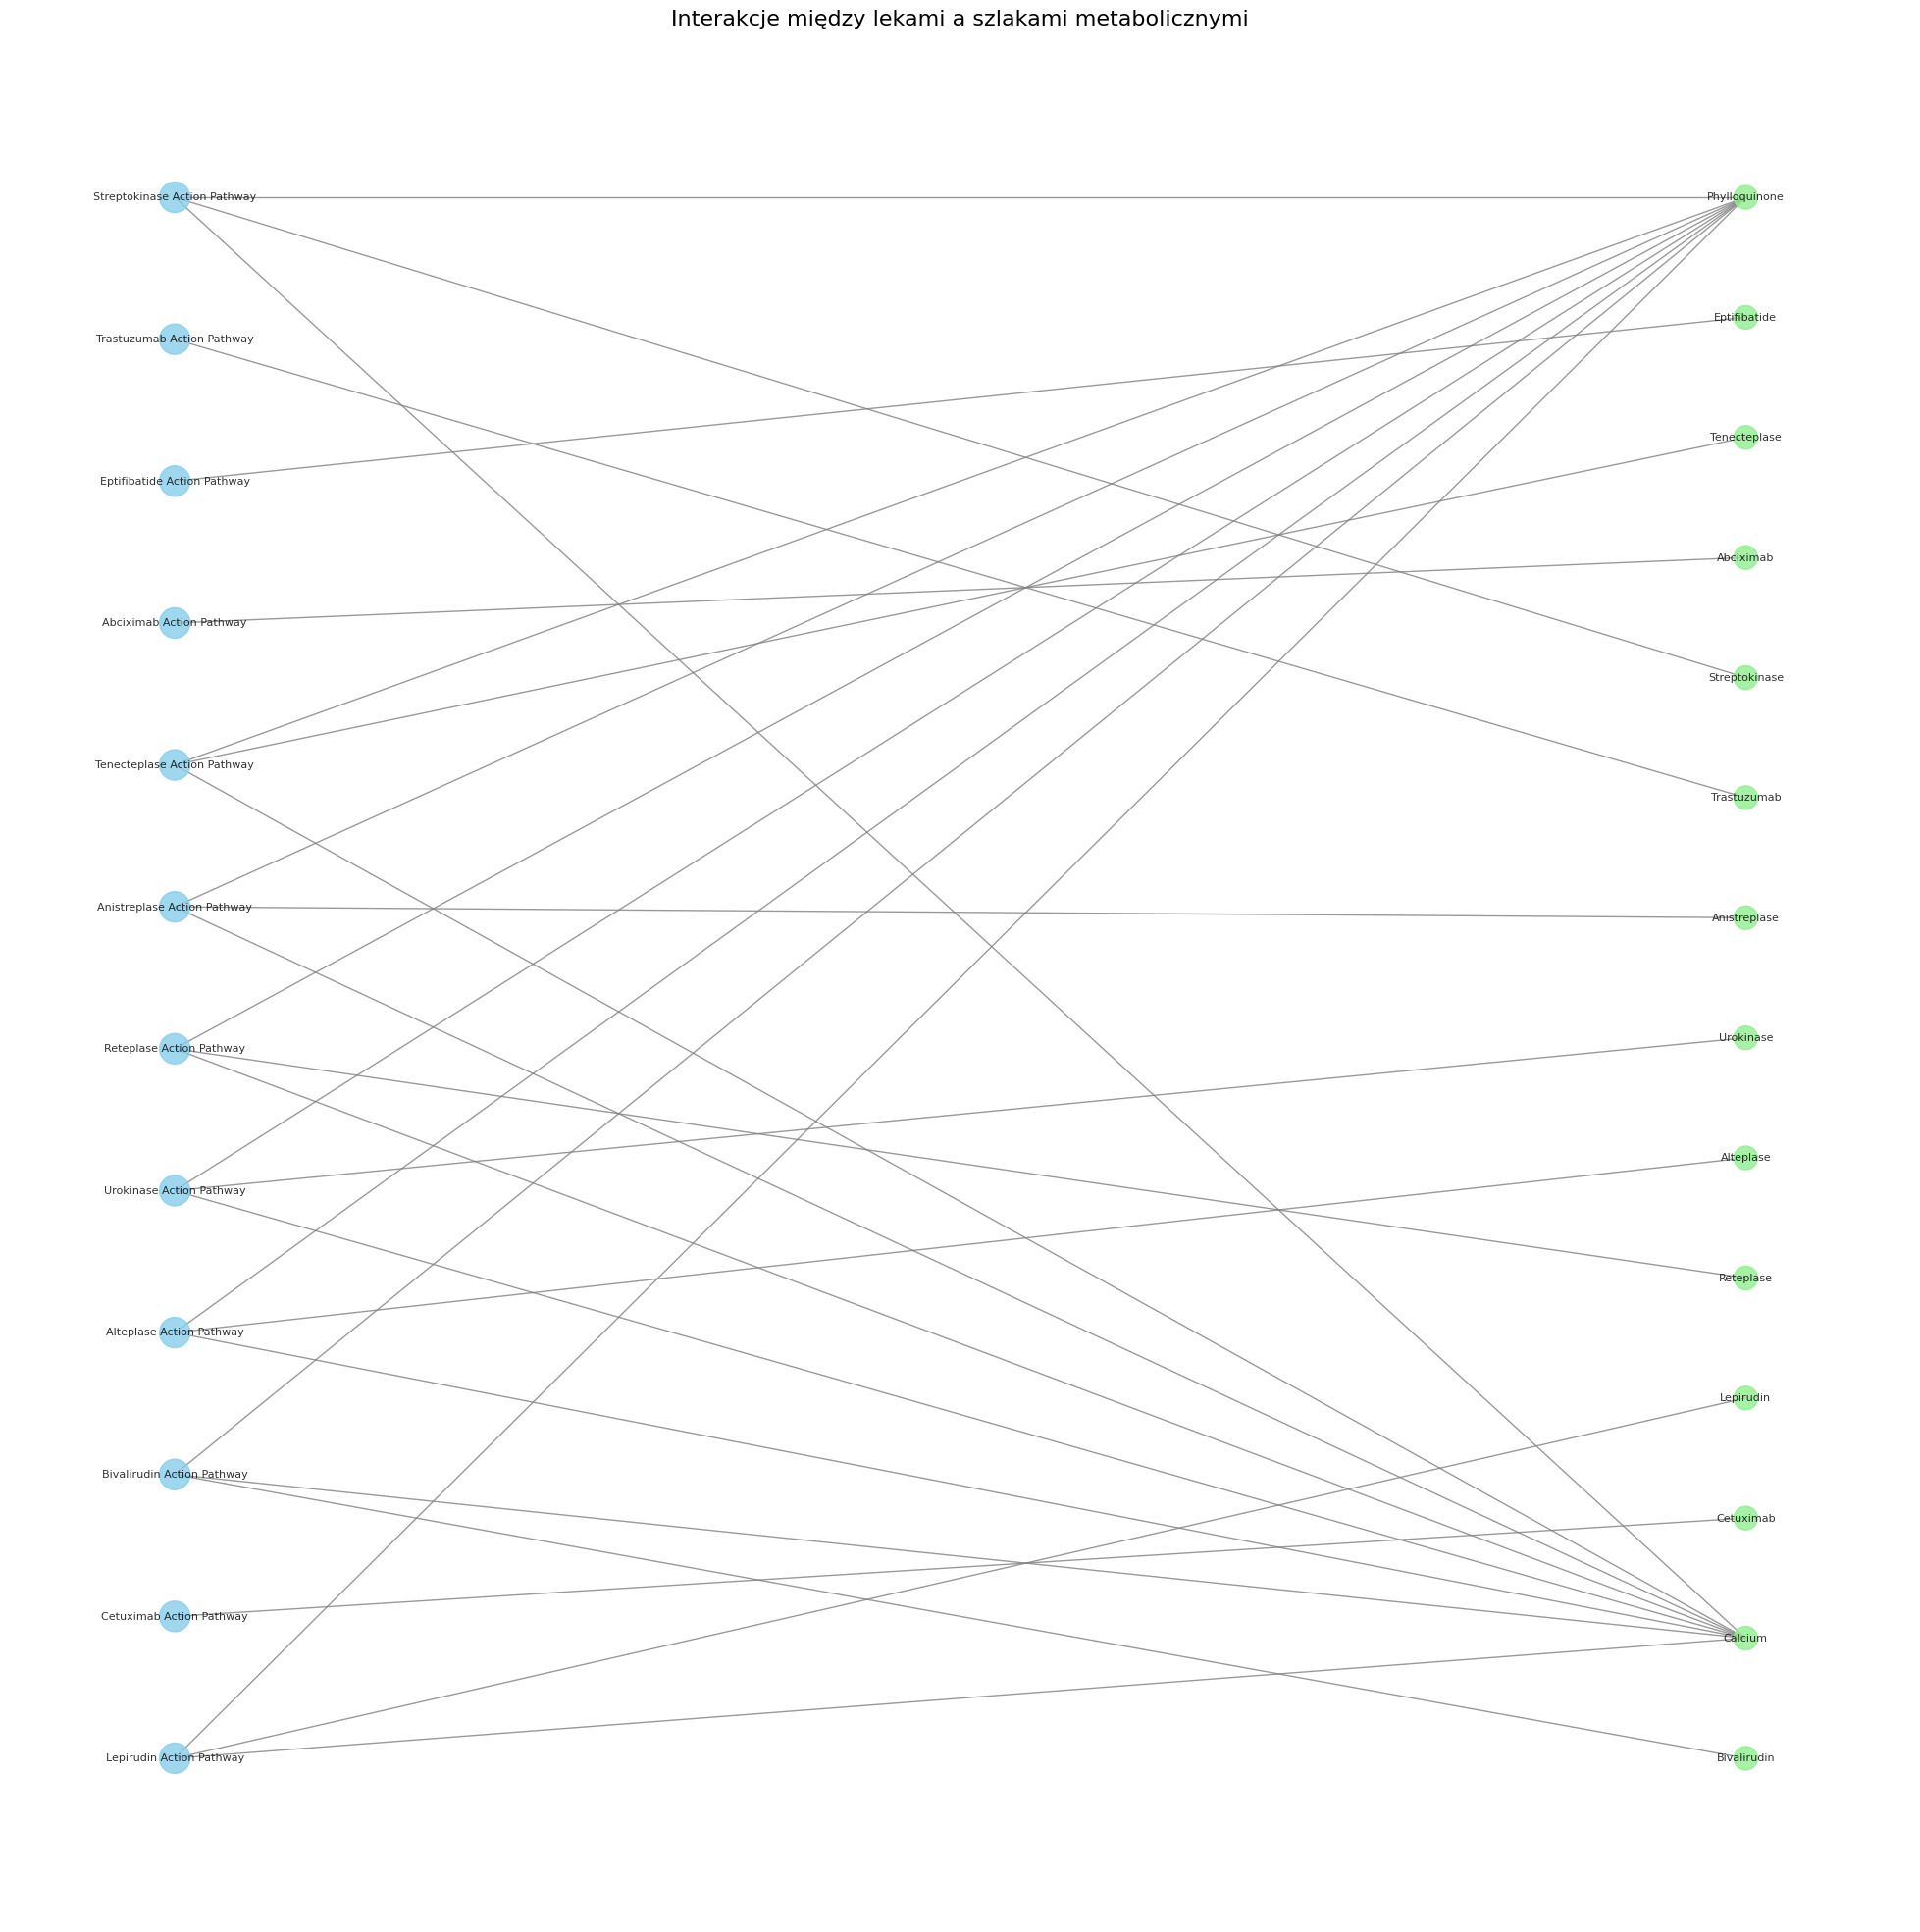

,Pathway,Drug
0,Lepirudin Action Pathway,Lepirudin
1,Lepirudin Action Pathway,Phylloquinone
2,Lepirudin Action Pathway,Calcium
3,Cetuximab Action Pathway,Cetuximab
4,Bivalirudin Action Pathway,Bivalirudin
5,Bivalirudin Action Pathway,Phylloquinone
6,Bivalirudin Action Pathway,Calcium
7,Alteplase Action Pathway,Alteplase
8,Alteplase Action Pathway,Phylloquinone
9,Alteplase Action Pathway,Calcium


In [86]:
import xml.etree.ElementTree as ET
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

tree = ET.parse('drugbank_partial.xml')
root = tree.getroot()
ns = {'db': 'http://www.drugbank.ca'}

pathway_interactions = {}

for pathway in root.findall('.//db:pathway', ns):
    pathway_name = pathway.find('db:name', ns).text
    drugs_in_pathway = []
    
    for drug in pathway.findall('db:drugs/db:drug', ns):
        drug_id = drug.find('db:drugbank-id', ns).text
        drug_name = drug.find('db:name', ns).text
        drugs_in_pathway.append((drug_id, drug_name))
    
    pathway_interactions[pathway_name] = drugs_in_pathway

pathway_list = []
drugs_list = []
for pathway, drugs in pathway_interactions.items():
    for drug in drugs:
        pathway_list.append(pathway)
        drugs_list.append(drug[1])

df = pd.DataFrame({
    'Pathway': pathway_list,
    'Drug': drugs_list
})

G = nx.Graph()

pathways = list(pathway_interactions.keys())
drugs = list(set(df['Drug']))

G.add_nodes_from(pathways, bipartite=0, color='skyblue', type='pathway')
G.add_nodes_from(drugs, bipartite=1, color='lightgreen', type='drug')

for _, row in df.iterrows():
    G.add_edge(row['Pathway'], row['Drug'])

plt.figure(figsize=(25, 25))
pos = nx.bipartite_layout(G, pathways, align='vertical')

colors = [G.nodes[n]['color'] for n in G.nodes]
sizes = [500 if G.nodes[n]['type'] == 'pathway' else 300 for n in G.nodes]

nx.draw_networkx(
    G,
    pos=pos,
    with_labels=True,
    node_color=colors,
    node_size=sizes,
    edge_color='gray',
    font_size=8,
    alpha=0.8
)

plt.title('Interakcje między lekami a szlakami metabolicznymi', fontsize=16)
plt.box(False)
plt.show()

df.to_csv('pathway_drug_interactions.csv', index=False)
df

## Zadanie 6

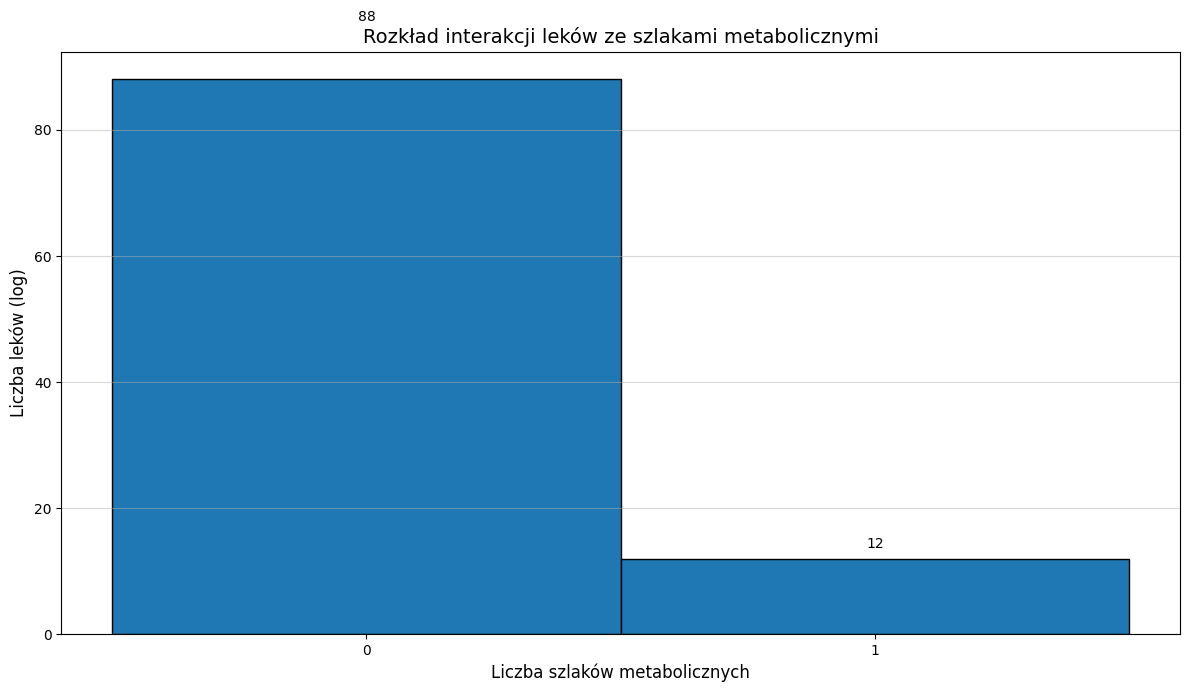

,Drug ID,Pathway Count
0,DB00047,0
1,DB00043,0
2,DB00065,0
3,DB00026,0
4,DB00062,0
...,...,...
95,DB00044,0
96,DB00049,0
97,DB00042,0
98,DB00071,0


In [87]:
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
from collections import defaultdict
ns = {'db': 'http://www.drugbank.ca'}

all_drug_ids = set()
for drug in root.findall('db:drug', ns):
    primary_id = drug.find('db:drugbank-id[@primary="true"]', ns)
    if primary_id is not None:
        all_drug_ids.add(primary_id.text)

drug_pathway_counts = defaultdict(int)
for drug_id in all_drug_ids:
    drug_pathway_counts[drug_id] = 0

for pathway in root.findall('.//db:pathway', ns):
    for drug in pathway.findall('db:drugs/db:drug', ns):
        drug_id = drug.find('db:drugbank-id', ns).text
        if drug_id in drug_pathway_counts:
            drug_pathway_counts[drug_id] += 1

counts = list(drug_pathway_counts.values())

plt.figure(figsize=(12, 7))
n, bins, patches = plt.hist(counts, 
                           bins=range(0, max(counts)+2), 
                           align='left',
                           edgecolor='black',
                           log=False)

plt.xlabel('Liczba szlaków metabolicznych', fontsize=12)
plt.ylabel('Liczba leków (log)', fontsize=12)
plt.title('Rozkład interakcji leków ze szlakami metabolicznymi', fontsize=14)
plt.xticks(range(0, max(counts)+1))
plt.grid(axis='y', alpha=0.5)

for i in range(len(patches)):
    plt.text(bins[i], 
            n[i]*1.1, 
            str(int(n[i])), 
            ha='center', 
            va='bottom')

plt.tight_layout()
plt.show()

pd.DataFrame(drug_pathway_counts.items(), columns=['Drug ID', 'Pathway Count'])

## Zadanie 7

In [88]:
target_data = []

for drug in root.findall('db:drug', namespace):
    drug_id = drug.find('db:drugbank-id', namespace).text
    drug_name = drug.find('db:name', namespace).text

    for target in drug.findall('.//db:target', namespace):
        target_id = target.find('db:id', namespace).text if target.find('db:id', namespace) is not None else None
        
        polypeptide = target.find('db:polypeptide', namespace)
        if polypeptide is not None:
            gene_name = polypeptide.find('db:gene-name', namespace)
            chromosome = polypeptide.find('db:chromosome-location', namespace)
            cellular_location = polypeptide.find('db:cellular-location', namespace)

            external_source = polypeptide.get('source')
            external_id = polypeptide.get('id')

            genatlas_id = None
            for ext_id in polypeptide.findall('.//db:external-identifier', namespace):
                resource = ext_id.find('db:resource', namespace)
                identifier = ext_id.find('db:identifier', namespace)
                if resource is not None and identifier is not None and resource.text == "GenAtlas":
                    genatlas_id = identifier.text
                    break

        else:
            gene_name = chromosome = cellular_location = external_source = external_id = genatlas_id = None

        target_data.append({
            'DrugBank_ID': drug_id,
            'Drug_Name': drug_name,
            'Target_ID': target_id,
            'Source': external_source,
            'External_ID': external_id,
            'Polypeptide_Name': polypeptide.find('db:name', namespace).text if polypeptide is not None else None,
            'Gene_Name': gene_name.text if gene_name is not None else None,
            'GenAtlas_ID': genatlas_id,
            'Chromosome_Location': chromosome.text if chromosome is not None else None,
            'Cellular_Location': cellular_location.text if cellular_location is not None else None
        })

df_targets = pd.DataFrame(target_data)

df_targets

,DrugBank_ID,Drug_Name,Target_ID,Source,External_ID,Polypeptide_Name,Gene_Name,GenAtlas_ID,Chromosome_Location,Cellular_Location
0,DB00001,Lepirudin,BE0000048,Swiss-Prot,P00734,Prothrombin,F2,F2,11,Secreted
1,DB00002,Cetuximab,BE0000767,Swiss-Prot,P00533,Epidermal growth factor receptor,EGFR,EGFR,7,Cell membrane
2,DB00002,Cetuximab,BE0000901,Swiss-Prot,O75015,Low affinity immunoglobulin gamma Fc region re...,FCGR3B,FCGR3B,1,Cell membrane
3,DB00002,Cetuximab,BE0002094,Swiss-Prot,P02745,Complement C1q subcomponent subunit A,C1QA,C1QA,1,Secreted
4,DB00002,Cetuximab,BE0002095,Swiss-Prot,P02746,Complement C1q subcomponent subunit B,C1QB,C1QB,1,Secreted
...,...,...,...,...,...,...,...,...,...,...
262,DB00107,Oxytocin,BE0000844,Swiss-Prot,P30559,Oxytocin receptor,OXTR,OXTR,3,Cell membrane
263,DB00108,Natalizumab,BE0000590,Swiss-Prot,P13612,Integrin alpha-4,ITGA4,ITGA4,2,Membrane
264,DB00108,Natalizumab,BE0000901,Swiss-Prot,O75015,Low affinity immunoglobulin gamma Fc region re...,FCGR3B,FCGR3B,1,Cell membrane
265,DB00108,Natalizumab,BE0000710,Swiss-Prot,P12314,High affinity immunoglobulin gamma Fc receptor I,FCGR1A,FCGR1A,1,Cell membrane


## Zadanie 8

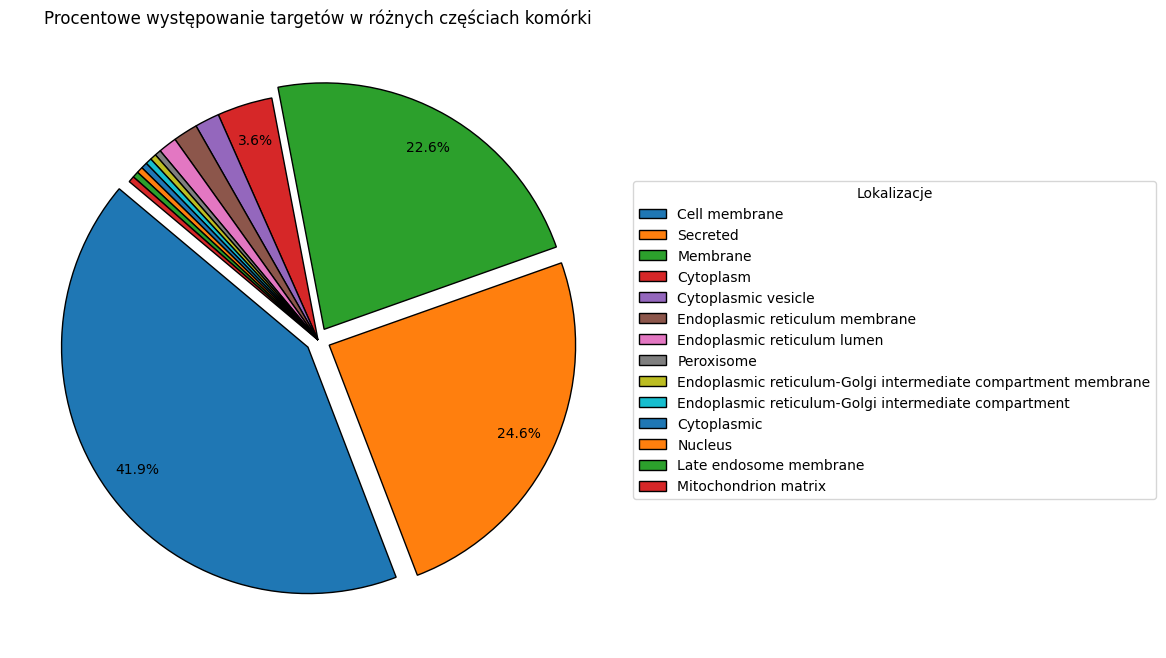

In [89]:
location_counts = df_targets['Cellular_Location'].value_counts()

labels = location_counts.index
sizes = location_counts.values

def autopct_format(pct):
    return f'{pct:.1f}%' if pct > 3 else ''  # Pokazuje % tylko jeśli większe niż 3%

fig, ax = plt.subplots(figsize=(12, 8))
wedges, texts, autotexts = ax.pie(
    sizes,
    labels=None,
    autopct=autopct_format,
    startangle=140,
    wedgeprops={'edgecolor': 'black'},
    pctdistance=0.85,
    explode=[0.05 if s > (max(sizes) * 0.3) else 0 for s in sizes]
)

ax.legend(wedges, labels, title="Lokalizacje", loc="center left", bbox_to_anchor=(1, 0.5), fontsize=10)

plt.title('Procentowe występowanie targetów w różnych częściach komórki')

plt.show()

## Zadanie 9

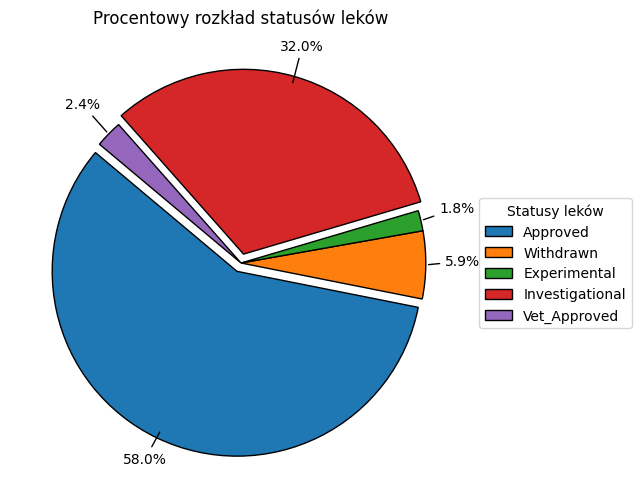

Liczba zatwierdzonych leków, które NIE zostały wycofane: 89


,Status,Count
0,Approved,98
1,Withdrawn,10
2,Experimental,3
3,Investigational,54
4,Vet_Approved,4


In [90]:
drug_statuses = []

for drug in root.findall('db:drug', namespace):
    drug_id = drug.find('db:drugbank-id', namespace).text
    drug_name = drug.find('db:name', namespace).text

    groups = drug.findall('.//db:group', namespace)
    statuses = [group.text for group in groups] if groups else []

    drug_statuses.append({
        'DrugBank_ID': drug_id,
        'Drug_Name': drug_name,
        'Approved': 'approved' in statuses,
        'Withdrawn': 'withdrawn' in statuses,
        'Experimental': 'experimental' in statuses,
        'Investigational': 'investigational' in statuses,
        'Vet_Approved': 'vet_approved' in statuses
    })

df_statuses = pd.DataFrame(drug_statuses)

status_counts = {
    'Approved': df_statuses['Approved'].sum(),
    'Withdrawn': df_statuses['Withdrawn'].sum(),
    'Experimental': df_statuses['Experimental'].sum(),
    'Investigational': df_statuses['Investigational'].sum(),
    'Vet_Approved': df_statuses['Vet_Approved'].sum()
}

approved_not_withdrawn = df_statuses[(df_statuses['Approved'] == True) & (df_statuses['Withdrawn'] == False)].shape[0]

df_status_counts = pd.DataFrame(list(status_counts.items()), columns=['Status', 'Count'])

fig, ax = plt.subplots(figsize=(10, 6))

sizes = list(status_counts.values())
labels = list(status_counts.keys())

wedges, texts, autotexts = ax.pie(
    sizes,
    labels=None,
    autopct='',
    startangle=140,
    wedgeprops={'edgecolor': 'black'},
    pctdistance=0.85,
    explode=[0.05 if s > (max(sizes) * 0.3) else 0 for s in sizes]
)

for i, wedge in enumerate(wedges):
    angle = (wedge.theta2 + wedge.theta1) / 2  # Środek kąta klina
    x = 1.2 * wedge.r * np.cos(np.radians(angle))  # Współrzędne X
    y = 1.2 * wedge.r * np.sin(np.radians(angle))  # Współrzędne Y

    ax.annotate(
        f"{sizes[i] / sum(sizes) * 100:.1f}%",  # Format procentów
        xy=(wedge.r * np.cos(np.radians(angle)), wedge.r * np.sin(np.radians(angle))),
        xytext=(x, y),  # Położenie tekstu obok
        ha="center", fontsize=10, 
        arrowprops=dict(arrowstyle="-", color="black")  # Łącząca linia
    )

ax.legend(wedges, labels, title="Statusy leków", loc="center left", bbox_to_anchor=(1, 0.5), fontsize=10)

plt.title('Procentowy rozkład statusów leków')

plt.show()
print(f"Liczba zatwierdzonych leków, które NIE zostały wycofane: {approved_not_withdrawn}")

df_status_counts

## Zadanie 10

In [91]:
interactions_data = []

for drug in root.findall('db:drug', namespace):
    drug_id = drug.find('db:drugbank-id', namespace).text
    drug_name = drug.find('db:name', namespace).text 

    for interaction in drug.findall('.//db:drug-interaction', namespace):
        interacting_drug_id = interaction.find('db:drugbank-id', namespace)
        interacting_drug_name = interaction.find('db:name', namespace)
        interaction_description = interaction.find('db:description', namespace)

        interactions_data.append({
            'DrugBank_ID': drug_id,
            'Drug_Name': drug_name,
            'Interacting_Drug_ID': interacting_drug_id.text if interacting_drug_id is not None else None,
            'Interacting_Drug_Name': interacting_drug_name.text if interacting_drug_name is not None else None,
            'Interaction_Description': interaction_description.text if interaction_description is not None else None
        })

df_interactions = pd.DataFrame(interactions_data)

df_interactions

,DrugBank_ID,Drug_Name,Interacting_Drug_ID,Interacting_Drug_Name,Interaction_Description
0,DB00001,Lepirudin,DB06605,Apixaban,Apixaban may increase the anticoagulant activi...
1,DB00001,Lepirudin,DB06695,Dabigatran etexilate,Dabigatran etexilate may increase the anticoag...
2,DB00001,Lepirudin,DB01254,Dasatinib,The risk or severity of bleeding and hemorrhag...
3,DB00001,Lepirudin,DB01609,Deferasirox,The risk or severity of gastrointestinal bleed...
4,DB00001,Lepirudin,DB01586,Ursodeoxycholic acid,The risk or severity of bleeding and bruising ...
...,...,...,...,...,...
50683,DB00108,Natalizumab,DB14766,Etrasimod,The risk or severity of immunosuppression can ...
50684,DB00108,Natalizumab,DB15043,Toripalimab,The risk or severity of adverse effects can be...
50685,DB00108,Natalizumab,DB18701,"Chikungunya vaccine (live, attenuated)",The risk or severity of infection can be incre...
50686,DB00108,Natalizumab,DB18705,SARS-CoV-2 virus recombinant spike (S) protein...,The therapeutic efficacy of SARS-CoV-2 virus r...


## Zadanie 11

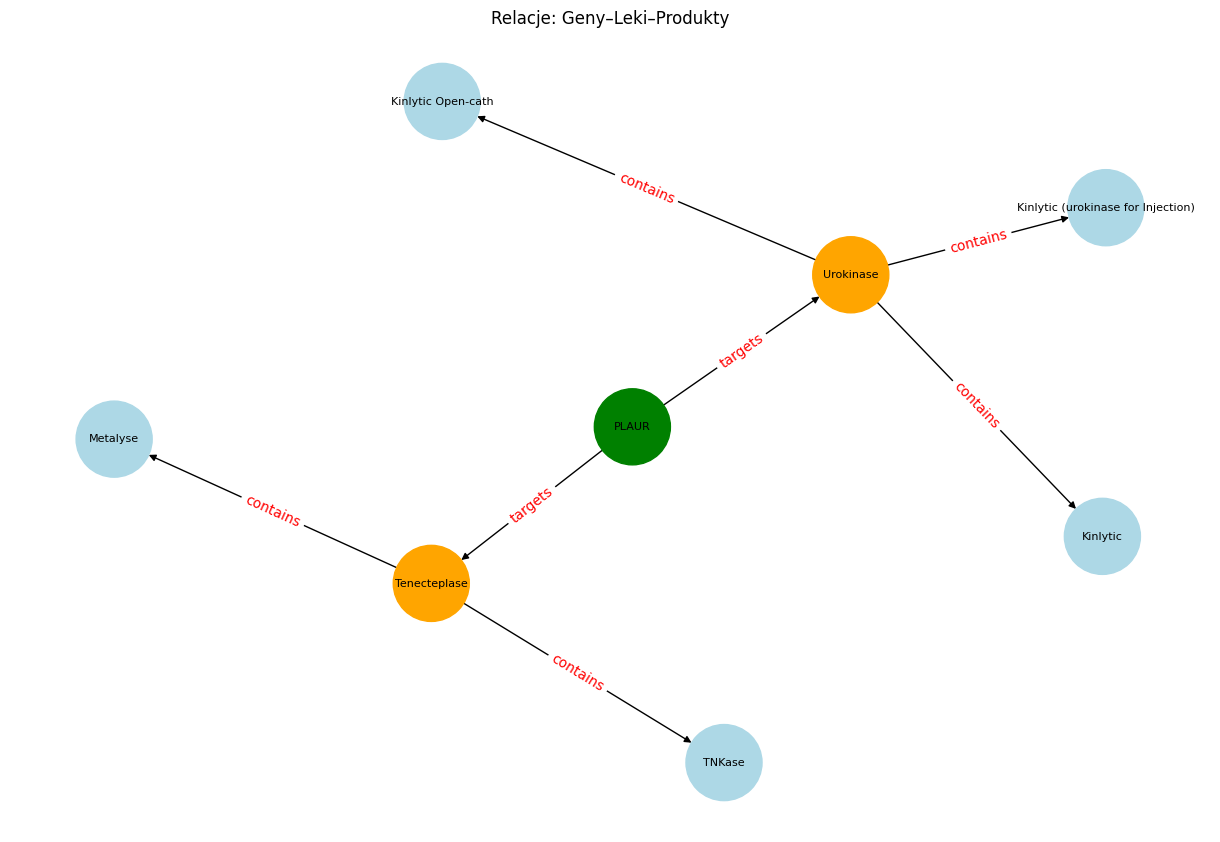

In [92]:
def build_gene_drug_graph(xml_file, gene_list):
    tree = ET.parse(xml_file)
    root = tree.getroot()
    ns = {'db': 'http://www.drugbank.ca'}

    drug_to_genes = {}
    drug_to_products = {}

    for drug_el in root.findall("db:drug", ns):
        name_el = drug_el.find("db:name", ns)
        if name_el is None:
            continue
        drug_name = name_el.text.strip()

        genes_found = set()

        targets = drug_el.findall("db:targets/db:target", ns)
        for target in targets:
            polypep = target.find("db:polypeptide", ns)
            if polypep is not None:
                gene_name_el = polypep.find("db:gene-name", ns)
                if gene_name_el is not None:
                    gene_found = gene_name_el.text.strip()
                    genes_found.add(gene_found)

        drug_to_genes[drug_name] = genes_found

        products = []
        for p in drug_el.findall("db:products/db:product", ns):
            prod_name_el = p.find("db:name", ns)
            if prod_name_el is not None:
                products.append(prod_name_el.text.strip())

        drug_to_products[drug_name] = products

    G = nx.DiGraph()

    for gene in gene_list:
        G.add_node(gene, type='gene')

    for drug_name, geneset in drug_to_genes.items():
        common = geneset.intersection(gene_list)
        if common:
            G.add_node(drug_name, type='drug')
            for g in common:
                G.add_edge(g, drug_name, label='targets')

            products = drug_to_products.get(drug_name, [])
            for prod_name in products:
                G.add_node(prod_name, type='product')
                G.add_edge(drug_name, prod_name, label='contains')

    return G

gene_list = ["PLAUR"]
G = build_gene_drug_graph(xml_file, gene_list)

pos = nx.spring_layout(G, k=1.0)

node_colors = []
for node, data in G.nodes(data=True):
    if data.get('type') == 'gene':
        node_colors.append('green')
    elif data.get('type') == 'drug':
        node_colors.append('orange')
    else:  # product
        node_colors.append('lightblue')

plt.figure(figsize=(12, 8))
nx.draw(
    G, pos,
    with_labels=True,
    node_color=node_colors,
    node_size=3000,
    font_size=8,
    arrows=True
)

# Etykiety krawędzi
edge_labels = nx.get_edge_attributes(G, 'label')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red')

plt.title("Relacje: Geny–Leki–Produkty")
plt.show()

## Zadanie 12

Pobieranie danych chorób: 100%|██████████| 85/85 [01:55<00:00,  1.36s/it]

{'Thrombophilia due to thrombin defect', 'Factor II deficiency', 'Ischemic stroke', 'Pregnancy loss, recurrent, 2'}
    Drug ID  Liczba chorób                                            Choroby
0   DB00001              4  Thrombophilia due to thrombin defect, Factor I...
1   DB00002              6  C1q deficiency 1, C1q deficiency 2, Immunodefi...
2   DB00004              5  Severe combined immunodeficiency X-linked T-ce...
3   DB00005              4  Psoriatic arthritis, C1q deficiency 1, Systemi...
4   DB00006              4  Thrombophilia due to thrombin defect, Factor I...
..      ...            ...                                                ...
80  DB00102             10  Gastrointestinal stromal tumor, Myeloprolifera...
81  DB00105              2  Immunodeficiency 106, susceptibility to viral ...
82  DB00106              1  Hypogonadotropic hypogonadism 7 with or withou...
83  DB00107              0                                        Brak danych
84  DB00108              0

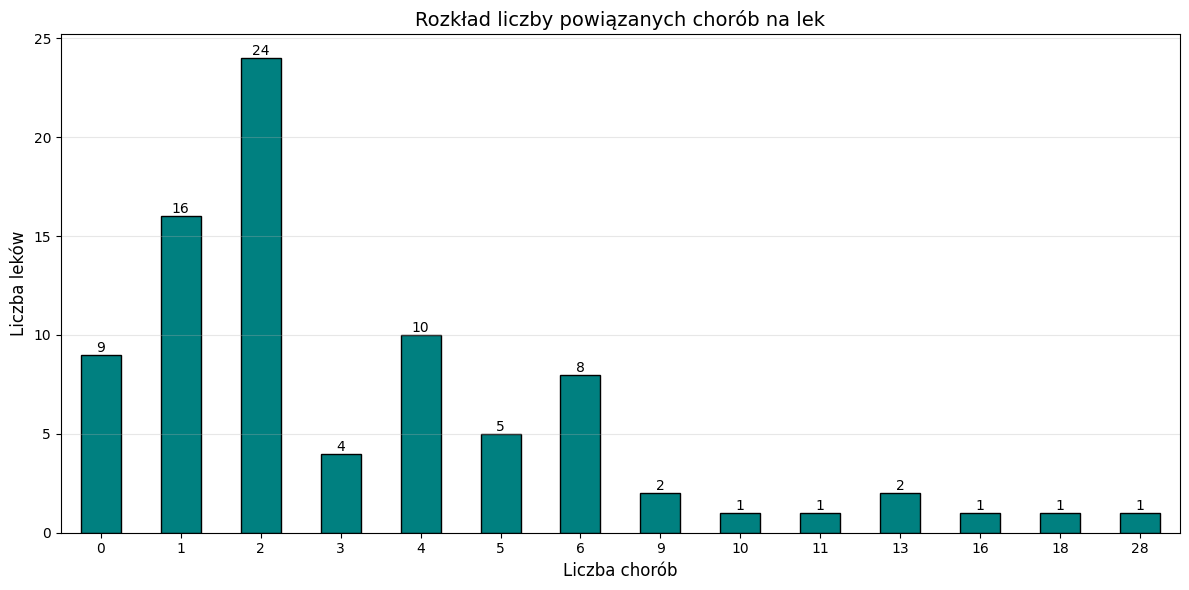

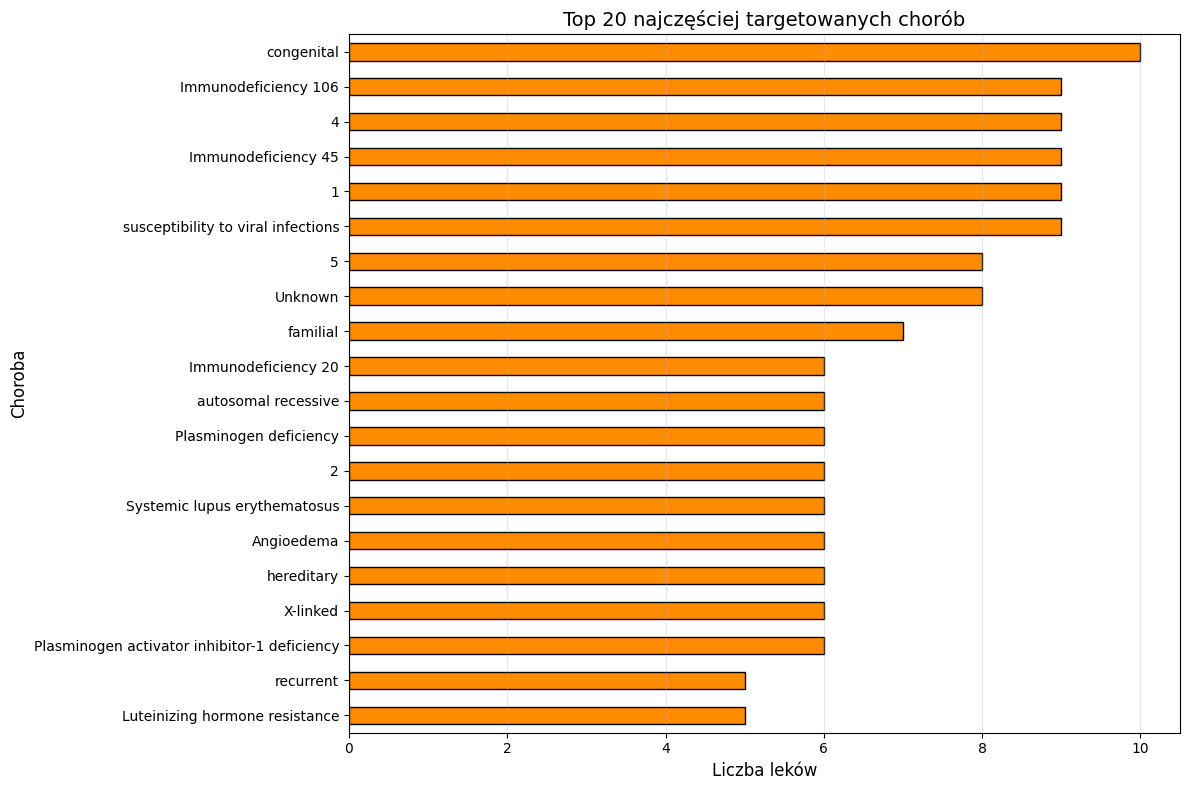

(np.float64(-1.1582263485836577),
 np.float64(1.2048454356112206),
 np.float64(-1.1418843501716522),
 np.float64(1.2035274721882565))

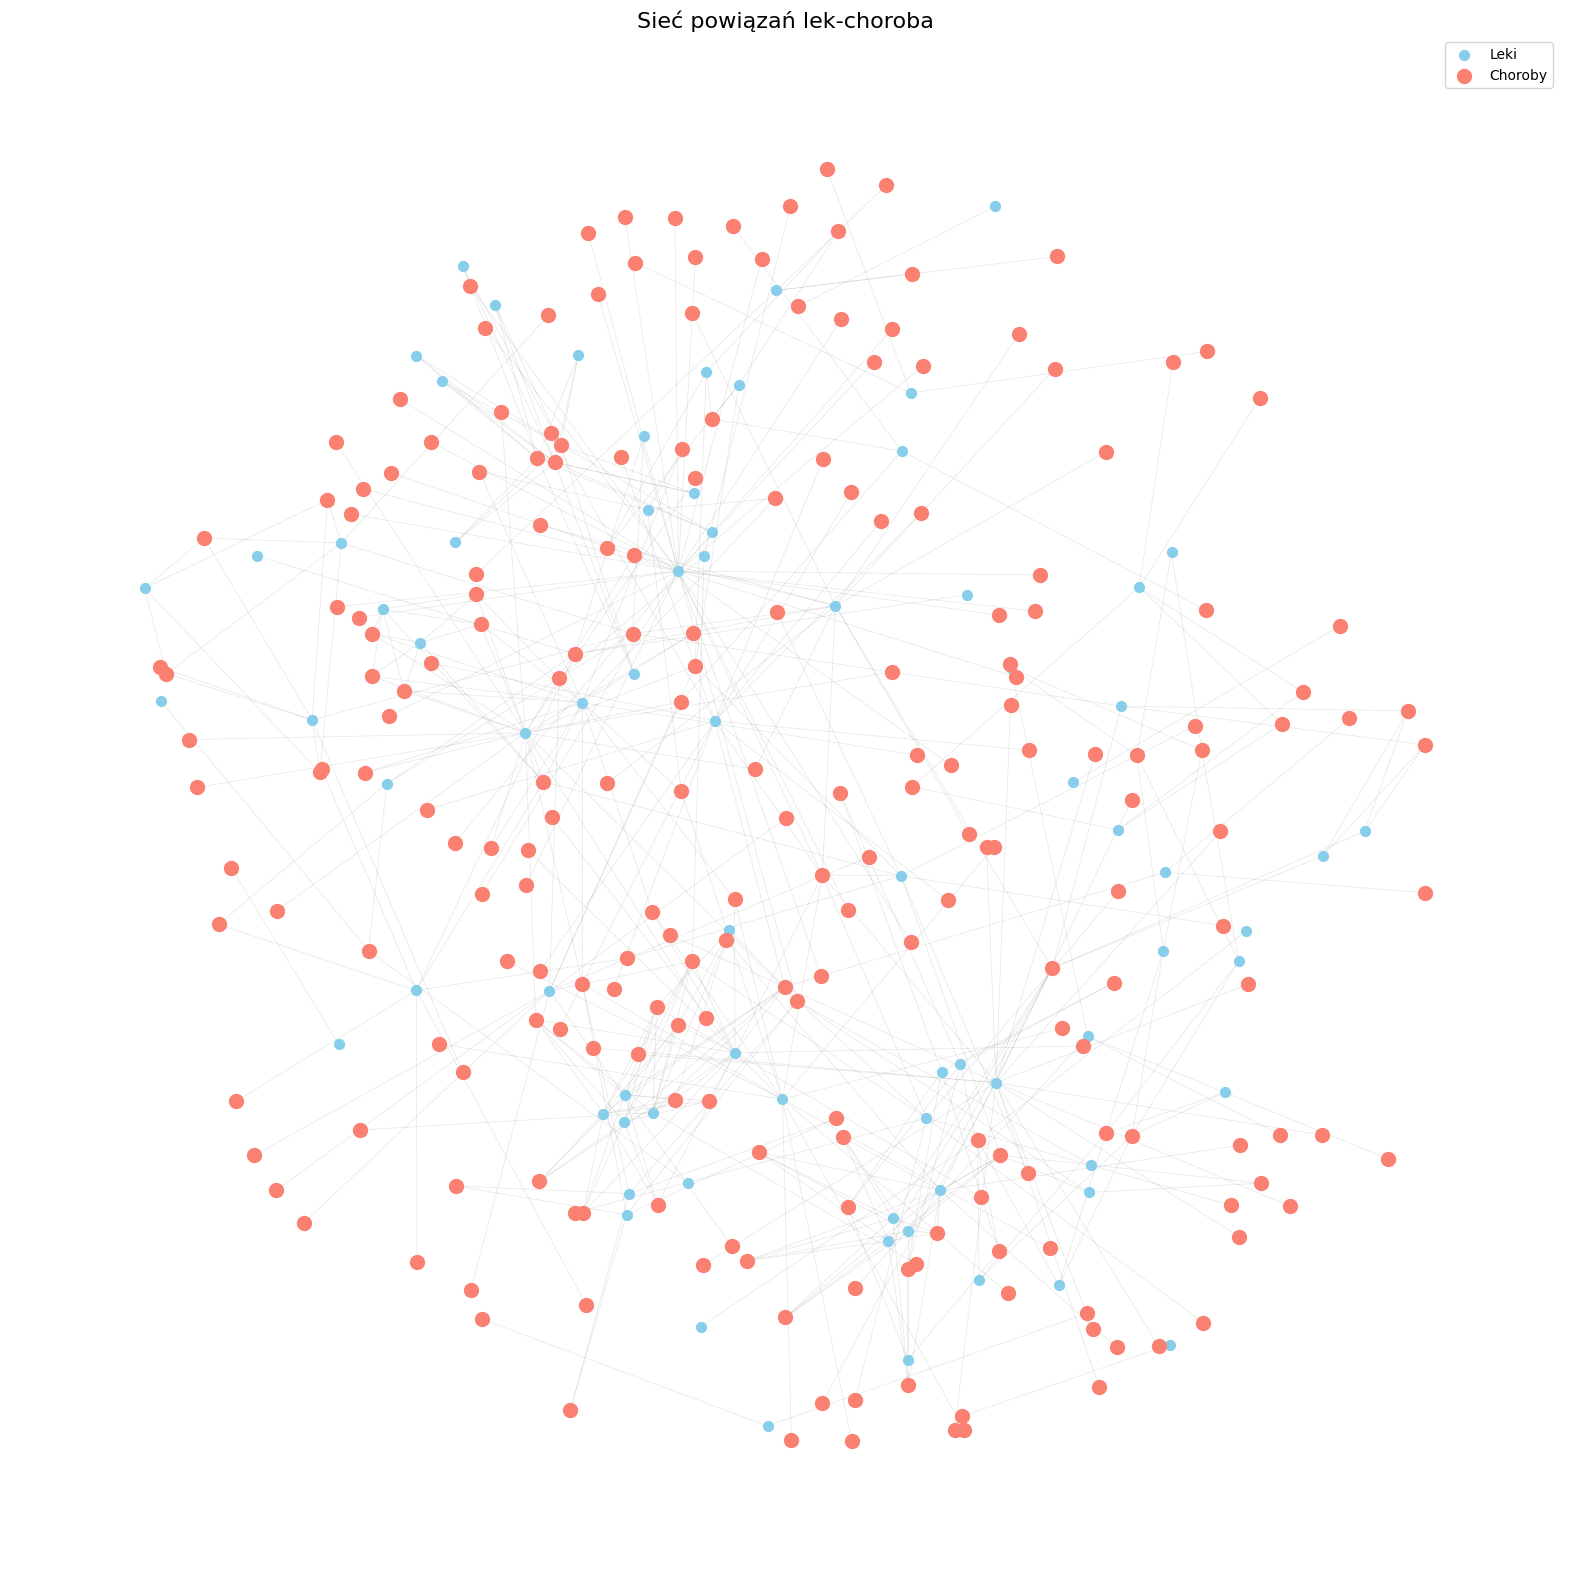

In [93]:
import xml.etree.ElementTree as ET
import requests
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict
from tqdm import tqdm
import time

UNIPROT_API = "https://www.uniprot.org/uniprot/"
DELAY = 0.5

tree = ET.parse('drugbank_partial.xml')
root = tree.getroot()
ns = {'db': 'http://www.drugbank.ca'}

drug_targets = defaultdict(list)

for drug in tqdm(root.findall('db:drug', ns), desc="Przetwarzanie leków"):
    drug_id = drug.find('db:drugbank-id[@primary="true"]', ns).text
    targets = drug.findall('.//db:targets/db:target', ns)
    
    for target in targets:
        uniprot_id = target.find('db:polypeptide/db:external-identifiers/db:external-identifier[db:resource="UniProtKB"]/db:identifier', ns)
        if uniprot_id is not None:
            drug_targets[drug_id].append(uniprot_id.text)

drug_diseases = defaultdict(set)
uniprot_cache = {}


for drug_id, uniprot_ids in tqdm(drug_targets.items(), desc="Pobieranie danych chorób"):
    for uniprot_id in uniprot_ids:
        if uniprot_id in uniprot_cache:
            diseases = uniprot_cache[uniprot_id]
        else:
            try:
                response = requests.get(f"{UNIPROT_API}{uniprot_id}.json")
                if response.status_code == 200:
                    data = response.json()
                    diseases = set()
                    for comment in data.get('comments', []):
                        if comment['commentType'] == 'DISEASE':
                            disease = comment.get('disease', {})
                            diseases.add(disease.get('diseaseId', 'Unknown'))
                    uniprot_cache[uniprot_id] = diseases
                else:
                    diseases = set()
                time.sleep(DELAY)
            except Exception as e:
                print(f"Błąd dla {uniprot_id}: {str(e)}")
                diseases = set()
        
        drug_diseases[drug_id].update(diseases)
print(drug_diseases['DB00001'])

analysis_data = []
for drug_id, diseases in drug_diseases.items():
    analysis_data.append({
        'Drug ID': drug_id,
        'Liczba chorób': len(diseases),
        'Choroby': ', '.join(diseases) if diseases else 'Brak danych'
    })

df = pd.DataFrame(analysis_data)
print(df)

plt.figure(figsize=(12, 6))
ax = df['Liczba chorób'].value_counts().sort_index().plot(
    kind='bar',
    color='teal',
    edgecolor='black'
)

plt.title('Rozkład liczby powiązanych chorób na lek', fontsize=14)
plt.xlabel('Liczba chorób', fontsize=12)
plt.ylabel('Liczba leków', fontsize=12)
plt.xticks(rotation=0)
plt.grid(axis='y', alpha=0.3)

for p in ax.patches:
    ax.annotate(f"{int(p.get_height())}", 
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', 
                xytext=(0, 5), 
                textcoords='offset points')

plt.tight_layout()
plt.show()

all_diseases = [disease for sublist in df['Choroby'].str.split(', ') for disease in sublist if disease != 'Brak danych']
disease_counts = pd.Series(all_diseases).value_counts().head(20)

plt.figure(figsize=(12, 8))
ax = disease_counts.sort_values().plot(
    kind='barh',
    color='darkorange',
    edgecolor='black'
)

plt.title('Top 20 najczęściej targetowanych chorób', fontsize=14)
plt.xlabel('Liczba leków', fontsize=12)
plt.ylabel('Choroba', fontsize=12)
plt.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

from itertools import product

edges = []
for _, row in df.iterrows():
    if row['Choroby'] != 'Brak danych':
        diseases = row['Choroby'].split(', ')
        edges.extend([(row['Drug ID'], disease) for disease in diseases])

import networkx as nx

G = nx.Graph()
G.add_edges_from(edges)

plt.figure(figsize=(20, 20))
pos = nx.spring_layout(G, k=0.3, seed=42)

nx.draw_networkx_nodes(
    G, pos,
    nodelist=[n for n in G.nodes if n in df['Drug ID'].values],
    node_color='skyblue',
    node_size=50,
    label='Leki'
)

nx.draw_networkx_nodes(
    G, pos,
    nodelist=[n for n in G.nodes if n not in df['Drug ID'].values],
    node_color='salmon',
    node_size=100,
    label='Choroby'
)

nx.draw_networkx_edges(
    G, pos,
    width=0.5,
    alpha=0.2,
    edge_color='grey'
)

plt.title('Sieć powiązań lek-choroba', fontsize=16)
plt.legend(scatterpoints=1, frameon=True)
plt.axis('off')
# plt.show()

## Zadanie 13

In [94]:
import xml.etree.ElementTree as ET
import random

ns = {'db': 'http://www.drugbank.ca'}

def parse_existing_drugs(xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()

    existing_data = []

    for drug_el in root.findall("db:drug", ns):
        drug_type = drug_el.attrib.get("type", "small_molecule")  # domyślnie
        name_el = drug_el.find("db:name", ns)
        desc_el = drug_el.find("db:description", ns)
        groups_el = drug_el.find("db:groups", ns)

        name_text = name_el.text.strip() if (name_el is not None and name_el.text) else "Unknown drug"
        desc_text = desc_el.text.strip() if (desc_el is not None and desc_el.text) else "No description"
        
        group_texts = []
        if groups_el is not None:
            for group_el in groups_el.findall("db:group", ns):
                if group_el.text:
                    group_texts.append(group_el.text.strip())

        existing_data.append({
            "type": drug_type,
            "name": name_text,
            "description": desc_text,
            "groups": group_texts
        })

    return existing_data


def generate_extended_db(input_file, output_file, how_many=10):

    tree = ET.parse(input_file)
    root = tree.getroot()

    existing_drugs_data = parse_existing_drugs(input_file)
    if not existing_drugs_data:
        print("Brak istniejących leków do wykorzystania jako wzorce!")
        return

    last_drug_id_num = 10000  # rezerwujemy wartość początkową
    for drug_el in root.findall("db:drug", ns):
        primary_id = drug_el.find('db:drugbank-id[@primary="true"]', ns)
        if primary_id is not None:
            db_id_text = primary_id.text
            if db_id_text.startswith("DB") and db_id_text[2:].isdigit():
                num_part = int(db_id_text[2:])
                if num_part > last_drug_id_num:
                    last_drug_id_num = num_part

    generated_drugs = []
    for i in range(how_many):
        new_num = last_drug_id_num + i + 1
        new_id = f"DB{new_num}"

        template = random.choice(existing_drugs_data)

        new_drug = ET.Element("{http://www.drugbank.ca}drug", type=template["type"])

        drugbank_id = ET.SubElement(new_drug, "{http://www.drugbank.ca}drugbank-id", attrib={"primary": "true"})
        drugbank_id.text = new_id

        name_el = ET.SubElement(new_drug, "{http://www.drugbank.ca}name")
        name_el.text = f"{template['name']} SIM-{i+1}"  # dopisujemy np. SIM-1

        desc_el = ET.SubElement(new_drug, "{http://www.drugbank.ca}description")
        desc_el.text = template["description"]

        groups_el = ET.SubElement(new_drug, "{http://www.drugbank.ca}groups")
        for g_text in template["groups"]:
            group_elem = ET.SubElement(groups_el, "{http://www.drugbank.ca}group")
            group_elem.text = g_text

        generated_drugs.append(new_drug)

    for new_drug in generated_drugs:
        root.append(new_drug)

    tree.write(output_file, encoding="utf-8", xml_declaration=True)
    print(f"Generated XML file saved as: {output_file}. Dodano {how_many} nowych leków.")


if __name__ == "__main__":
    input_xml = "drugbank_partial.xml"
    output_xml = "drugbank_partial_and_generated.xml"
    how_many_new_drugs = 19900

    generate_extended_db(input_xml, output_xml, how_many_new_drugs)

Generated XML file saved as: drugbank_partial_and_generated.xml. Dodano 19900 nowych leków.


Wygenerowana baza jest odpalana na podpunktach 1-12 w notebooku `p13.ipynb`.

## Zadanie 14

W pliku `p14.py` znajdują się testy testujące przepisaną wersję podpunktu 12 do pliku `drugank_analysis.py` (podzielone fragmenty kodu na funkcje, które są testowane).

Uruchamianie:
```sh
pytest p14.py
```

## Zadanie 15

W skrypcie `p15-server.py` jest podana implementacja serwera, który odczytując dane z pliku `drugbank_partial.xml` odpowiada na zapytania klienta o liczbę szlaków, z którymi powiązany jest dany w zapytaniu lek.

In [96]:
import requests

def main():
    url = "http://127.0.0.1:8000/get_pathway_count"
    drug_id = "DB00001"
    payload = {"drug_id": drug_id}

    response = requests.post(url, json=payload)
    if response.status_code == 200:
        data = response.json()
        print("Odpowiedź od serwera:")
        print(data)
    else:
        print("Błąd:", response.status_code, response.text)

if __name__ == "__main__":
    main()

Odpowiedź od serwera:
{'drug_id': 'DB00001', 'pathway_count': 1}
